### Research description

- Переменная notebook_mode в разделе "Notebook params" переключается между режимом обучения и режимом стриминга камеры. В первом случае модель начнет обучаться, во втором подгрузится модель с диска и попытается начать считывать поток с камеры.
- На отложенной выборке в пределах предложенного дата-сета качество хорошее (в текущей версии ноутбука в тестовый дата-сет попало совсем мало объектов - под конец обучения менял соотношения чтобы дообучиться на максимальном объеме данных), все объекты классифицируются правильно.
- При стриминге с камеры долго не получалось добиться хоть каких-то результатов, отличных от рандома, после долгих эксперименов оказалось что модели просто не хватало немного качества чтобы начать хоть что-то различать не на рафинированных данных из дата-сета, а на реальных фреймах с камеры где и фон присутствует и т.д.
- Качество текущей модели при считывании потока с камеры таково, что в темноте если так все организовать что фон становится затемненным и свет от монитора высвечивает только руку, можно увидеть, что модель работает, иногда сразу распознает жест, иногда надо этим жестом какое-то время покрутить/пошевелить, через какое-то время он начнет мелькать либо модель непрерывно будет уверена, и стабильно выдавать правильный лейбл.
- В классе CustomDatasetFromImages(Dataset) использовал аугментацию (вращение, зум, отражение), но по экспериментам качества это не прибавило, что странно, ожидал, что при таком небольшом дата-сете (он же, вроде, небольшой?) будет эффект.
- Какие-то интересности в качестве реакции на жесты не стал придумывать - все-таки качество классификации с камеры пока не огонь - просто вывожу распознанный класс и расзвесовку по всем классам для текущего фрейма.
- Сделал для себя импровизированный дашборд (в файле project_dashboard.ipynb), считывал им данные, которые логировал при обучении.
- Иногда обучение строил так, что обучался, потом что-то менял, дообучался, в данном случае в логи попала инфа из одного такого сегмента (не с самого начала обучения), и эти данные для меня выглядят странными. Здесь представлены данные с использованием аугментации. Странным при использовании аугментации показлись несколько моментов: а. Почему-то лосс на тесте почти сразу начал уходить ниже лосса на трейне и с приличным гепом шел так в процессе обучения, б. Лосс на тесте как-то очень странно уперся в конкретное число и бился об него ни на грамм не пробивая (0.977). Ну, допустим, на тесте идет сто процентное попадание в точку по классам, но почему лосс 0.977, а не 0 тогда, если не 100%, тогда почему так четко горизонтальный уровень держит.

### Notebook params

In [1]:
from enum import Enum

class NotebookMode(Enum):
    LEARNING = 0
    CAMERA_STREAMING = 1

# Режим ноутбука {LEARNING: режим обучения, CAMERA_STREAMING: лоудим модель, идет распознавание потока с веб-камеры}
notebook_mode = NotebookMode.CAMERA_STREAMING  

### Import

In [2]:
import os
from time import sleep
from datetime import datetime
from random import choice, randint, random
import cv2
import PIL
from PIL import Image

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.nn import functional as F
import torchvision.models as models

import matplotlib.pyplot as plt

from IPython.display import clear_output

PIL.Image.MAX_IMAGE_PIXELS = 933120000

### Variables

In [3]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

### Data preprocessing

#### Get classes list and dicts

In [4]:
classes = []

for dir_name, dirs, files in os.walk(os.path.join('data', 'leapGestRecog')):
    if len(dir_name.split('\\')) == 4:
        class_ = dir_name.split('\\')[-1].split('_')
        class_ = '_'.join(class_[1:])
        classes.append(class_)

classes = list(set(classes))

classes

['palm',
 'c',
 'down',
 'index',
 'fist_moved',
 'fist',
 'thumb',
 'l',
 'palm_moved',
 'ok']

In [5]:
int_to_classes = dict(enumerate(classes))

int_to_classes

{0: 'palm',
 1: 'c',
 2: 'down',
 3: 'index',
 4: 'fist_moved',
 5: 'fist',
 6: 'thumb',
 7: 'l',
 8: 'palm_moved',
 9: 'ok'}

In [6]:
classes_to_int = dict(zip(classes, [ind for ind in range(len(classes))]))

classes_to_int

{'palm': 0,
 'c': 1,
 'down': 2,
 'index': 3,
 'fist_moved': 4,
 'fist': 5,
 'thumb': 6,
 'l': 7,
 'palm_moved': 8,
 'ok': 9}

#### Get pics paths DataFrame

In [7]:
data = {'path': [], 'target': []}

for dir_name, dirs, files in os.walk(os.path.join('data', 'leapGestRecog')):
    if len(dir_name.split('\\')) == 4:
        class_ = dir_name.split('\\')[-1].split('_')
        class_ = '_'.join(class_[1:])
        for file_name in files:
            data['path'].append(os.path.join(dir_name, file_name))
            data['target'].append(class_)

In [8]:
df = pd.DataFrame(data)
df = df.sample(frac=1).reset_index(drop=True)

df.head(3)

,path,target
0,data\leapGestRecog\05\10_down\frame_05_10_0091...,down
1,data\leapGestRecog\04\09_c\frame_04_09_0045.png,c
2,data\leapGestRecog\09\06_index\frame_09_06_014...,index


In [9]:
df['target'] = df.apply(lambda row: classes_to_int[row['target']], axis=1)

df.head(3)

,path,target
0,data\leapGestRecog\05\10_down\frame_05_10_0091...,2
1,data\leapGestRecog\04\09_c\frame_04_09_0045.png,1
2,data\leapGestRecog\09\06_index\frame_09_06_014...,3


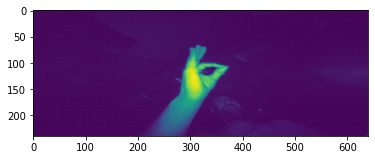

In [10]:
pic = plt.imread(df.loc[np.random.randint(0, df.shape[0]), 'path'])
plt.imshow(pic)
plt.show()

In [11]:
pic.shape

(240, 640)

#### Custom Dataset

In [12]:
class CustomDatasetFromImages(Dataset):
    def __init__(self, data_info: pd.DataFrame, augm_percent_size=0):
        self.data_info = data_info
        self.classes_count = 9
        self.size = int(self.data_info.shape[0] * (1 + float(augm_percent_size)/100))
        
        self.imgs_arr = self.data_info['path']
        self.target_arr = self.data_info['target']
        
    def __getitem__(self, index):
        if index < self.data_info.shape[0]:
            img = np.asarray(Image.open(self.imgs_arr[index])).astype('float')
            img = (torch.as_tensor(img) / 255).view(1, 1, img.shape[0], img.shape[1])  
            img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
            img = img.view(1, img.shape[-2], img.shape[-1])

            target = self.target_arr[index]

            return img.float(), target
        else:
            transformers = [0, 1, 1, 1, 1, 1, 1]
            tr = choice(transformers)
            
            rand_int_ = randint(0, self.data_info.shape[0]-1)
            
            if tr == 0:
                img = np.asarray(Image.open(self.imgs_arr[rand_int_])).astype('float')
                img = np.fliplr(img).copy()
            elif tr == 1:
                img = Image.open(self.imgs_arr[rand_int_])
                img = np.asarray(self.random_change(img)).astype('float')
            
            
            img = (torch.as_tensor(img) / 255).view(1, 1, img.shape[0], img.shape[1])  
            img = F.interpolate(input=img, size=256, align_corners=False, mode='bicubic')
            img = img.view(1, img.shape[-2], img.shape[-1])

            target = self.target_arr[rand_int_]

            return img.float(), target
    
    def random_change(self, img):
        zoom = ((random() + 0.5) * 2) - 0.5
        angle = randint(-45, 45)

        x, y = img.size
        x /= 2
        y /= 2

        w, h = img.size
        zoom2 = zoom * 2
        img = img.crop((x - w / zoom2, y - h / zoom2, 
                        x + w / zoom2, y + h / zoom2))
        img = img.resize((w, h), Image.LANCZOS)
        img = img.rotate(angle, Image.BICUBIC)

        return img

    def __len__(self):
        return self.size

In [13]:
# 70 % в тренировочную выборку, 30 - в тестовую
X_train, X_test = train_test_split(df, test_size=0.025)

# Упорядочиваем индексацию
X_train.reset_index(drop=True,inplace=True)
X_test.reset_index(drop=True,inplace=True)

# Оборачиваем каждую выборку в наш кастомный датасет
train_data = CustomDatasetFromImages(data_info=X_train, augm_percent_size=250)
test_data = CustomDatasetFromImages(X_test)

torch.Size([1, 256, 256])


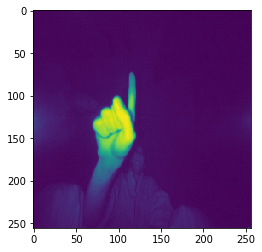

In [14]:
for val in train_data:
    plt.imshow(val[0][0])
    print(val[0].shape)
    break

In [15]:
train_data_loader = DataLoader(train_data, batch_size=25, shuffle=True)
test_data_loader = DataLoader(test_data, batch_size=25, shuffle=True)

### Learning

#### Learning params

In [16]:
do_learning = True
learning_rate = 0.0001
epochs = 10

#### Model, loss function, optimizer

###### Models_reserch

###### Model

In [17]:
# id003
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.batchnorm1 = nn.BatchNorm2d(num_features=6)
        self.batchnorm2 = nn.BatchNorm2d(num_features=16)
        self.pool = nn.MaxPool2d(3, 3)
        self.dropout = nn.Dropout(0.25)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*26*26, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.tanh = nn.Tanh()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.batchnorm1(x)
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv2(x)))
        x = self.batchnorm2(x)
        x = self.dropout(x)
        x = x.view(-1, 16*26*26)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.tanh(x)

        return x


net = Net().to(device)

###### Loss function

In [18]:
loss_func = nn.CrossEntropyLoss()

###### Optimizer

In [19]:
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

#### Learning loop

In [20]:
def evaluate_test(n=10):
    losses_ = []
    for i, data in enumerate(test_data_loader, 0):
        inputs, labels = data
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        losses_.append(loss.item())
#         print(torch.argmax(outputs, dim=1), labels)
#         print(loss_func(outputs, labels))
        
        if i > n:
            return round(np.array(losses_).mean(), 3)
            break
    return round(np.array(losses_).mean(), 3)
            
evaluate_test(10)

2.297

In [23]:
losses_train = []
losses_test = []

for epoch in range(epochs):
    
    if notebook_mode != NotebookMode.LEARNING:
        break

    running_loss = 0.0
    for i, data in enumerate(train_data_loader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()
        
        print_every = 25
        

        running_loss += loss.item()
        if i % print_every == 0 and i != 0:
            test_mean_loss = evaluate_test(n=10)
            losses_test.append(test_mean_loss)
            print(f'[{epoch}, {i}] loss_train: {round(running_loss / print_every, 3)}, loss_test: {test_mean_loss},'
                  f' {datetime.now()}')
            losses_train.append(running_loss / print_every)
            losses_df = pd.DataFrame({'loss_train': losses_train, 'loss_test': losses_test})
            losses_df.to_csv('losses.csv', index=False)
            try:
                losses_df.to_csv(r'C:\Users\misha\OneDrive\Data Science\interactions\losses.csv', index=False)
            except:
                pass
            running_loss = 0.0
            
            softmax = nn.Softmax(dim=0)
            vector_ = [round(val, 3) for val in outputs[0].tolist()]
            max_ = torch.argmax(torch.Tensor(vector_)).item()
            target_ = labels[0].item()

            
#             print('match:', target_ == max_, 'target:', target_, 'max:', max_, 'X:', softmax(torch.Tensor(vector_)))


#### Save model

In [24]:
if notebook_mode == NotebookMode.LEARNING:
    model_path = os.path.join('models', 'model_0.797_id003.model')
    torch.save(net.state_dict(), model_path)

#### Load model

In [25]:
if notebook_mode == NotebookMode.CAMERA_STREAMING:
    net = Net().to(device)
    model_path = os.path.join('models', 'model_0.797_id003.model')
    net.load_state_dict(torch.load(model_path))

In [26]:
net.parameters

<bound method Module.parameters of Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (batchnorm1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (batchnorm2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.25, inplace=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=10816, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (tanh): Tanh()
  (softmax): Softmax(dim=1)
)>

#### Evaluate model

In [27]:
ev = 0

In [28]:
pred_ = []
true_ = []
max_ = []

for i, data in enumerate(test_data_loader, 0):
    inputs, labels = data
    outputs = net(inputs)
    ev = inputs
    
    for ind in range(inputs.shape[0]):
        pic = inputs[ind][0]
        true_label = labels[ind]
        predict_label = outputs[ind]
        full_predict = predict_label

        true_label = int_to_classes[true_label.item()]
        predict_label = int_to_classes[torch.max(predict_label, dim=0)[1].item()]
        
        pred_.append(predict_label)
        true_.append(true_label)
        max_.append(torch.max(full_predict).item())

In [29]:
results_ = pd.DataFrame({'pred': pred_, 'true': true_, 'max': max_})
results_['match'] = 0
results_.loc[results_['pred'] == results_['true'], 'match'] = 1

results_

,pred,true,max,match
0,palm_moved,index,1.000000,0
1,fist_moved,down,1.000000,0
2,thumb,palm,1.000000,0
3,palm,fist_moved,1.000000,0
4,index,c,1.000000,0
...,...,...,...,...
495,thumb,palm,1.000000,0
496,palm,fist_moved,0.999961,0
497,down,fist,1.000000,0
498,down,fist,0.999930,0


In [30]:
val = 0.25
round(results_.loc[results_['max'] > val, 'match'].mean(), 5)

0.108

In [31]:
results_.loc[results_['match'] == 0].shape

(446, 4)

### Camera stream

#### Extra functions

На вход изображение с камеры (фрейм), на выходе изображение переформатированное под вход модели.

In [32]:
def cam_output_to_net_input(pic: torch.Tensor):  # pic - torch.Size([480, 640, 3])
    pic = np.dot(pic[...,:3], [0.2989, 0.5870, 0.1140])
    pic /= 255
    
    plt.imshow(pic)
    plt.plot()
    pic = torch.Tensor(pic)
    pic = pic.view(1, 1, pic.shape[0], pic.shape[1])
    pic = F.interpolate(input=pic, size=256, align_corners=False, mode='bicubic')[0].permute(1,2,0)
    pic = pic[:, :, 0]
    plt.imshow(pic/255)
    pic = pic.view(1, pic.shape[0], pic.shape[1])

    return pic

In [33]:
def predic_by_pic(pic):
    pic = cam_output_to_net_input(pic)
    outputs = net(pic.unsqueeze(0))

    predict_label = outputs[0]
    softmax = nn.Softmax(dim=0)
    vector = softmax(outputs[0]).tolist()
    
    argmax = torch.max(predict_label, dim=0)[1].item()
    predict_label = int_to_classes[argmax] if predict_label.max() > prob_limit else 'UNKNOWN'

    return predict_label, vector

#### Stream loop

In [34]:
prob_limit = 0.425

cap = cv2.VideoCapture(0)

counter = 0
evaluate_every = 1

while True:
    counter += 1
    ret, frame = cap.read()
    cv2.imshow('App', frame)
    
#     frame = torch.Tensor(frame)
    
#     pic = torch.Tensor(cv2.imread('gesture.png'))
    if counter % evaluate_every == 0:
        clear_output(wait=True)
        predict = predic_by_pic(frame)
        
#         softmax = nn.Softmax(dim=0)
#         vector = softmax(predict[1]).tolist()
#         vector = dict([(int_to_classes[val[0]], round(val[1], 3)) for val in enumerate(vector)])
#         print(vector)
#         raise Exception()
        print(predict[0] , predict[1])
        
        
#         pic = torch.Tensor(pic)
#     isWritten = cv2.imwrite('gesture.png', frame)
    
        sleep(0.1)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

cap.release()
cv2.destroyAllWindows()

error: OpenCV(4.4.0) C:\Users\appveyor\AppData\Local\Temp\1\pip-req-build-6sxsq0tp\opencv\modules\highgui\src\window.cpp:376: error: (-215:Assertion failed) size.width>0 && size.height>0 in function 'cv::imshow'


In [ ]:
cap.release()
cv2.destroyAllWindows()